### Configuration

In [1]:
import os
import pandas as pd
import numpy as np

from scipy.stats import zscore
import tphate # requires Python 3.7 - 3.9

from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import utils__config
os.chdir(utils__config.working_directory)
os.getcwd()

'Z:\\Layton\\Sleep_083023'

### Parameters

In [3]:
spike_path = 'Cache/Subject05/Jul13/S05_spike_epochs_10s.csv'
swa_path = 'Cache/Subject05/Jul13/S05_sw_epochs_10s.csv'
hypno_path = 'Cache/Subject05/Jul13/S05_hypno_epochs_10s.csv' 
plot_path = 'Results/S05_Jul13_tphate_acc_10s.svg'

n_jobs = -4
micro_regions = ['ACC']

### Pre-Processing

In [4]:
# Load Data
spikes = pd.read_csv(spike_path)

# Calculate z-score of FR for units in the selected regions
spikes = spikes[spikes.unit_region.isin(micro_regions)]
spikes['zfr'] = spikes.groupby(['unit_id'])['fr'].transform(zscore).round(3)
spikes = spikes.pivot(index = 'epoch', columns = 'unit_id', values = 'zfr')
spikes.reset_index(drop = True, inplace = True)

# Save unit ids
unit_ids = spikes.columns.to_numpy()
spikes.columns.name = None
spikes.shape

# Load hypnogram data
hypno = pd.read_csv(hypno_path)

### Dimensionality Reduction

In [5]:
### T-PHATE dimensionality reduction for time autocorrelation
tp_model = tphate.TPHATE(n_jobs = n_jobs)
small_data = tp_model.fit_transform(spikes.to_numpy())

small_data.shape

Calculating TPHATE...
  Running TPHATE on 3744 observations and 6 variables.
  Landmarking not recommended; setting n_landmark to 3744
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.20 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.24 seconds.
  Learning the autocorrelation function...
  Calculating Autocorr kernel...
    Dropoff point: 715
  Combining PHATE operator and autocorr operator
  Calculating optimal t...
    Automatically selected t = 11
  Calculated optimal t in 18.98 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.58 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 54.59 seconds.
Calculated TPHATE in 80.18 seconds.


(3744, 2)

In [6]:
# Merge data with hypnogram information
pd_data = pd.DataFrame(small_data).reset_index()
pd_data.columns = ['epoch', 'TPHATE_1', 'TPHATE_2']
pd_data = pd_data.merge(hypno, on = ['epoch'])

# Map sleep stage numbers to sleep stages
stage_long_map = {
    -2: 'unscored',
    -1: 'artifact',
     0: 'wake',
     1: 'N1',
     2: 'N2',
     3: 'N3',
     4: 'REM'}

pd_data['stage_long'] = pd_data['stage'].map(stage_long_map)

# Map sleep stages to summary categories
stage_short_map = {
    'unscored': 'W/REM',
    'artifact': 'W/REM',
    'wake': 'W/REM',
    'N1': 'Light Sleep',
    'N2': 'Sleep',
    'N3': 'Sleep',
    'REM': 'W/REM'
}

pd_data['stage_short'] = pd_data['stage_long'].map(stage_short_map)

# Merge data with SWA information
swa_data = pd.read_csv(swa_path)
swa_data = swa_data.groupby('epoch')['zlog_power'].mean().reset_index()
pd_data = pd_data.merge(swa_data, on = 'epoch')

# Scale the zlog_power column
min_val = pd_data['zlog_power'].min()
max_val = pd_data['zlog_power'].max()
pd_data['zlog_power_scaled'] = (pd_data['zlog_power'] - min_val) / (max_val - min_val)

# Smooth the scaled zlog_power
sigma = 30
pd_data['zlog_power_smooth'] = gaussian_filter1d(pd_data['zlog_power_scaled'], sigma)

### Plotting

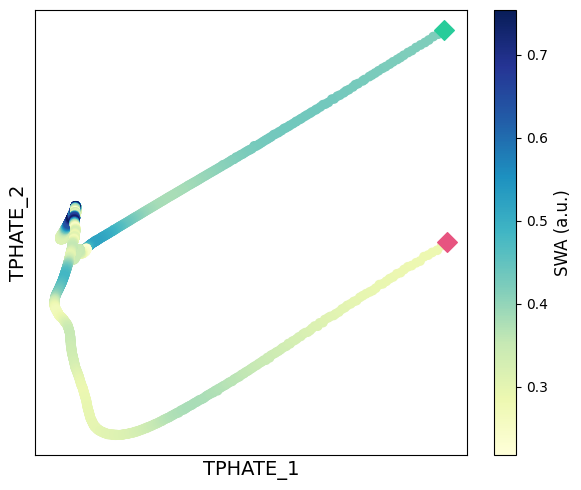

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Find starting point
start_point = pd_data[pd_data['epoch'] == 0][['TPHATE_1', 'TPHATE_2']].iloc[0]
end_point = pd_data.iloc[-1][['TPHATE_1', 'TPHATE_2']]

# Define the color palette
palette = sns.color_palette('YlGnBu', as_cmap=True) # or 'YlGnBu', 'flare', 'crest'

# Plotting with a wider figure
plt.figure(figsize=(6, 5))

# Use plt.scatter directly to get a mappable object
norm = plt.Normalize(pd_data['zlog_power_smooth'].min(), pd_data['zlog_power_smooth'].max())
sc = plt.scatter(pd_data['TPHATE_1'], pd_data['TPHATE_2'], c=pd_data['zlog_power_smooth'], cmap=palette, norm=norm, edgecolor=None, alpha=1)

# Add start and end points
plt.scatter(start_point['TPHATE_1'], start_point['TPHATE_2'], color="#28cc9a", s=100, label='Start', marker = 'D')
plt.scatter(end_point['TPHATE_1'], end_point['TPHATE_2'], color="#E75480", s=100, label='End', marker = 'D')

# Remove ticks and set larger axis labels
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.xlabel('TPHATE_1', fontsize=14)
plt.ylabel('TPHATE_2', fontsize=14)

# Add a colorbarW
cbar = plt.colorbar(sc)
cbar.set_label('SWA (a.u.)', fontsize=12)

plt.tight_layout()  # Adjust layout to ensure everything fits
plt.savefig(plot_path, format="svg", bbox_inches='tight')  # Ensure the saved figure includes the colorbar
plt.show()